In [1]:
import sys, os, cv2, json
import seaborn as sns
import pandas as pd, numpy as np, datetime as dt, matplotlib.pyplot as plt, pytz
from tqdm import tqdm
from itertools import combinations

In [2]:
import scienceplots
import matplotlib.ticker as ticker
plt.style.use(['science'])
FIG_WIDTH = 7.5  # width of figure in inches (a4 width)
TARGET_FOLDER = "/home/masc12/dev/masc12-mthesis/eda/img-eda/plots"

In [3]:
from astral.sun import sun # https://astral.readthedocs.io/en/latest/
from astral import LocationInfo
stgallen_city = LocationInfo('St. Gallen', 'Switzerland', 'Europe/Zurich', 47.424492554512014, 9.376722938498643)

In [4]:
webcams = ['altenrhein', 'ebenalp', 'golfclub-erlen', 'kronberg', 'romanshorn', 'rorschacherberg', 'sitterdorf', 'wiler-turm']
wbc_cmap = json.loads(open('webcam_colormap.json').read())

In [5]:
df_all_images = pd.DataFrame()
for wbc in webcams:
    img_files = os.listdir(f"../../data/{wbc}")
    img_ts = [dt.datetime.strptime(img.split(".")[0], "%Y-%m-%d_%H-%M-%S") for img in img_files]
    img_ts = [pytz.timezone('Europe/Zurich').localize(ts) for ts in img_ts]
    img_files = pd.DataFrame({"filename": img_files, "timestamp": img_ts, "webcam": wbc})
    img_files.sort_values("timestamp", inplace=True)
    img_files.reset_index(drop=True, inplace=True)
    df_all_images = pd.concat([df_all_images, img_files])

# Calculate earliest/latest image start/end

In [6]:
def  get_date_range_from(start, end):
    daterange = []
    while start <= end:
        daterange.append(start)
        start += dt.timedelta(minutes=10)
    return daterange

In [7]:
earliest_img_start = df_all_images.groupby("webcam")["timestamp"].min().min() 
latest_img_end     = df_all_images.groupby("webcam")["timestamp"].max().max()
earliest_img_start, latest_img_end

(Timestamp('2024-02-12 08:00:00+0100', tz='Europe/Zurich'),
 Timestamp('2025-03-14 15:10:00+0100', tz='Europe/Zurich'))

In [8]:
latest_img_start = df_all_images.groupby("webcam")["timestamp"].min().max()
earliest_img_end = df_all_images.groupby("webcam")["timestamp"].max().min()
latest_img_start, earliest_img_end

(Timestamp('2024-09-19 14:10:00+0200', tz='Europe/Zurich'),
 Timestamp('2025-03-14 12:10:00+0100', tz='Europe/Zurich'))

In [9]:
common_range_10min = get_date_range_from(latest_img_start, earliest_img_end)
total_range_10min = get_date_range_from(earliest_img_start, latest_img_end)

# Filter by Sunset/Sunrise

In [10]:
fetch_sun_times = lambda date: sun(stgallen_city.observer, date, tzinfo=stgallen_city.timezone)

In [11]:
def filter_dusk_dawn(daterange):
    new = []
    for x in daterange:
        sun_times = fetch_sun_times(x)
        if sun_times['dawn'] <= x <= sun_times['dusk']:
            new.append(x)
    return new

In [12]:
common_filtered_range_10min = filter_dusk_dawn(common_range_10min)
total_filtered_range_10min = filter_dusk_dawn(total_range_10min)

In [13]:
df_common = df_all_images[df_all_images["timestamp"].isin(common_filtered_range_10min)]
df_total = df_all_images[df_all_images["timestamp"].isin(total_filtered_range_10min)]

In [14]:
print(f"{len(df_all_images)} total images.")
print(f"{len(df_total)} total images during daylight hours (dawn to dusk)")
print(f"{len(df_common)} common images (all webcams have images in this interval)")

142123 total images.
119362 total images during daylight hours (dawn to dusk)
82864 common images (all webcams have images in this interval)


In [15]:
# total_range_daily = pd.date_range(
#     earliest_img_start,
#     latest_img_end
# )

# dusk_dawn_df = pd.DataFrame({
#     "ts": [x.date() for x in total_range_daily],
#     "dusk": [pd.to_datetime(fetch_sun_times(x)["dusk"]) for x in total_range_daily],
#     "dawn": [pd.to_datetime(fetch_sun_times(x)["dawn"]) for x in total_range_daily]
# })

# Pairwise intersection

In [16]:
def get_pairwise_intersection(df):
    pairwise_intersection = []

    for w1 in webcams:
        for w2 in webcams:
            a = set(df[df["webcam"] == w1]["timestamp"])
            b = set(df[df["webcam"] == w2]["timestamp"])
            
            intersection_size = len(a & b)  # Compute intersection
            pairwise_intersection.append((intersection_size, (w1, w2)))

    # Sort in descending order
    pairwise_intersection.sort(reverse=True, key=lambda x: x[0])
    return pairwise_intersection

In [17]:
def plot_intersection_heatmap(ax, intersection_list, sort, title):
    # Create an empty dataframe
    heatmap_data = pd.DataFrame(np.zeros((len(webcams), len(webcams))), 
                                index=webcams, columns=webcams)

    # Fill in pairwise intersection values
    for size, (w1, w2) in intersection_list:
        heatmap_data.loc[w1, w2] = size

    if sort:
        # Sort heatmap by the diagonal values in descending order
        sorted_indices = heatmap_data.values.diagonal().argsort()[::-1]
        heatmap_data = heatmap_data.iloc[sorted_indices, sorted_indices]

    # Plot heatmap on the given axis
    sns.heatmap(heatmap_data, ax=ax, annot=True, cmap="rocket_r", fmt=".0f", linewidths=0.5)
    ax.set_title(title)

In [18]:
pairwise_intersection_all = get_pairwise_intersection(df_all_images)
pairwise_intersection_common = get_pairwise_intersection(df_common)
pairwise_intersection_total = get_pairwise_intersection(df_total)

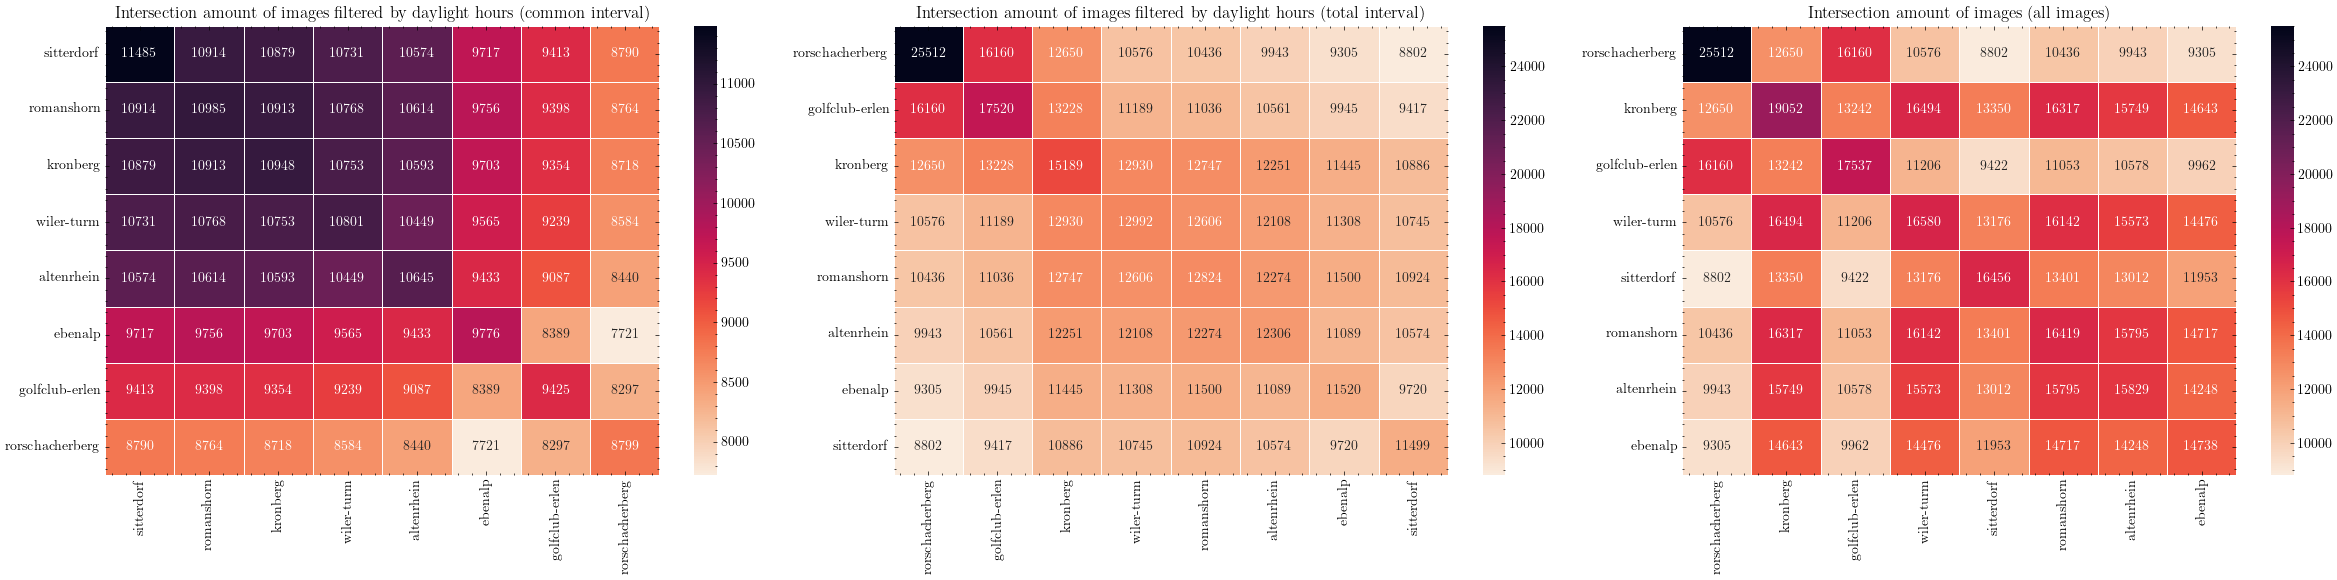

In [19]:
# Create side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))  # 1 row, 2 columns

plot_intersection_heatmap(axes[0], pairwise_intersection_common, sort=True, title="Intersection amount of images filtered by daylight hours (common interval)")
plot_intersection_heatmap(axes[1], pairwise_intersection_total, sort=True, title="Intersection amount of images filtered by daylight hours (total interval)")
plot_intersection_heatmap(axes[2], pairwise_intersection_all, sort=True, title="Intersection amount of images (all images)")

plt.tight_layout()
plt.show()

In [20]:
%%script False --no-raise-error

# FIGURE
plt.clf()
plt.figure(figsize=(FIG_WIDTH, 3))

# AXES
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# GRID
plt.grid(True)
plt.gca().set_axisbelow(True)

# LEGEND
handles = [plt.Rectangle((0,0),1,1, color=wbc_cmap[wbc]) for wbc in webcams]
plt.legend(handles, webcams, frameon=True, loc='upper left', handlelength=1, handleheight=1)

# SAVING
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/webcam-images-per-day.png", dpi=300)
plt.show()

Couldn't find program: 'False'


<Figure size 350x262.5 with 0 Axes>

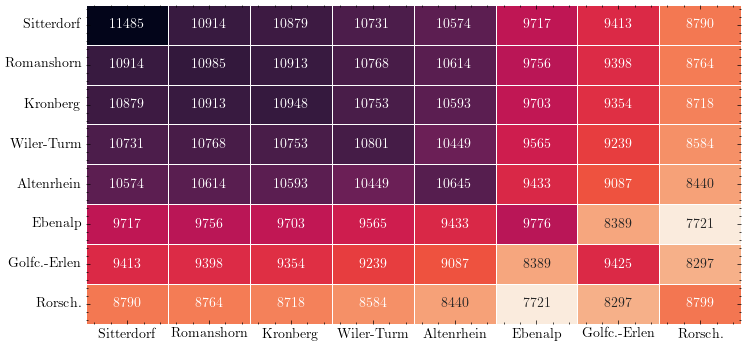

In [34]:
plt.clf()
plt.figure(figsize=(FIG_WIDTH, 3.5))

# plot_intersection_heatmap(axes[0], pairwise_intersection_common, sort=True, title="Intersection amount of images filtered by daylight hours (common interval)")
# def plot_intersection_heatmap(ax, intersection_list, sort, title):


heatmap_data = pd.DataFrame(np.zeros((len(webcams), len(webcams))), index=webcams, columns=webcams)

# Fill in pairwise intersection values
for size, (w1, w2) in pairwise_intersection_common:
    heatmap_data.loc[w1, w2] = size

sorted_indices = heatmap_data.values.diagonal().argsort()[::-1]
heatmap_data = heatmap_data.iloc[sorted_indices, sorted_indices]

# Prettify tick labels
pretty_labels = [w.title() for w in heatmap_data.index]
heatmap_data.index = [w.replace("Golfclub-Erlen", "Golfc.-Erlen") for w in pretty_labels]
heatmap_data.index = [w.replace("Rorschacherberg", "Rorsch.") for w in heatmap_data.index]
heatmap_data.columns = [w.replace("Golfclub-Erlen", "Golfc.-Erlen") for w in pretty_labels]
heatmap_data.columns = [w.replace("Rorschacherberg", "Rorsch.") for w in heatmap_data.columns]

# Plot heatmap on the given axis
sns.heatmap(heatmap_data, annot=True, cmap="rocket_r", fmt=".0f", linewidths=0.5, cbar=False)

plt.xticks(rotation=0)

plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/intersection-heatmap.png", dpi=300)
plt.show()

# Triplewise intersection

In [22]:
def get_triplewise_intersection(df):
    triplet_intersections = []

    for w1, w2, w3 in combinations(webcams, 3):
        a = set(df[df["webcam"] == w1]["timestamp"])
        b = set(df[df["webcam"] == w2]["timestamp"])
        c = set(df[df["webcam"] == w3]["timestamp"])
        
        intersection_size = len(a & b & c)  # Compute intersection
        triplet_intersections.append((intersection_size, (w1, w2, w3)))

    # Sort in descending order
    triplet_intersections.sort(reverse=False, key=lambda x: x[0])
    return triplet_intersections

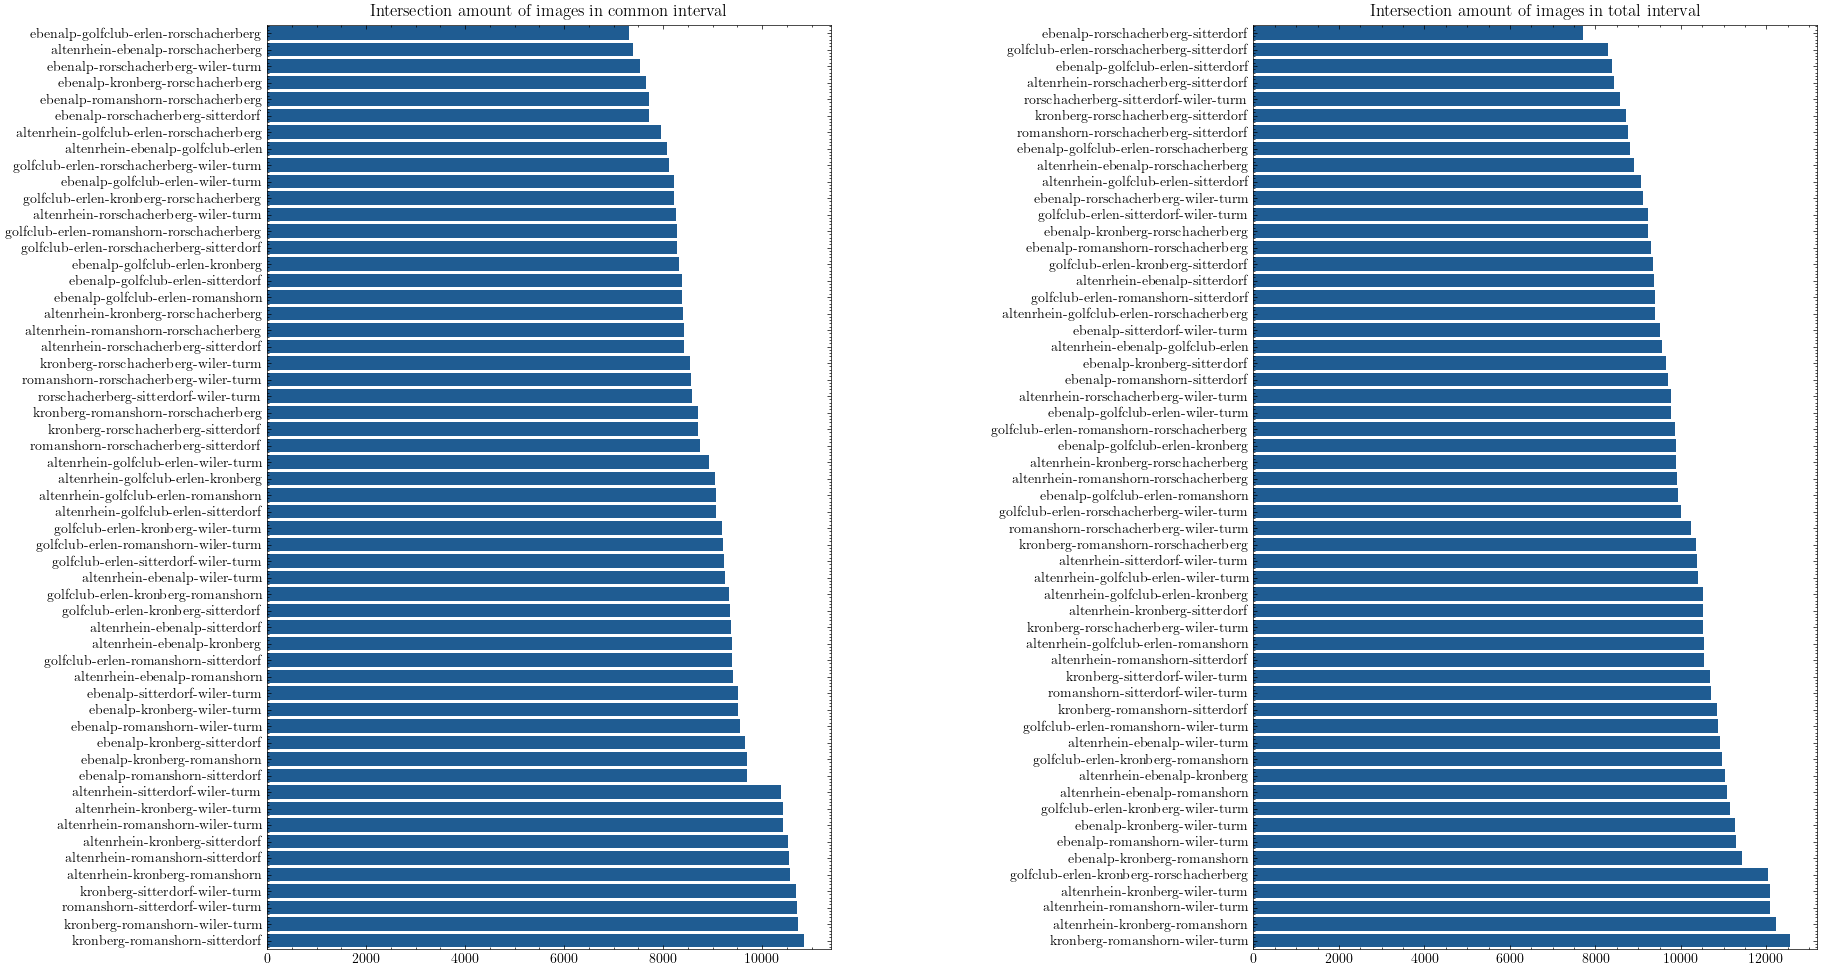

In [23]:
# bar chart
triplet_intersections_common = get_triplewise_intersection(df_common)
triplet_intersections_total = get_triplewise_intersection(df_total)

fig, ax = plt.subplots(1, 2, figsize=(20, 12))
sns.barplot(x=[x[0] for x in triplet_intersections_common], y=[f"{x[1][0]}-{x[1][1]}-{x[1][2]}" for x in triplet_intersections_common], ax=ax[0])
sns.barplot(x=[x[0] for x in triplet_intersections_total], y=[f"{x[1][0]}-{x[1][1]}-{x[1][2]}" for x in triplet_intersections_total], ax=ax[1])
# more space between subplots
plt.subplots_adjust(wspace=0.75)
ax[0].set_title("Intersection amount of images in common interval")
ax[1].set_title("Intersection amount of images in total interval")
plt.show()
